In [48]:
from becquerel import Spectrum
import numpy as np
import matplotlib.pyplot as plt
import becquerel as bq
import scipy.integrate as integrate
import math as m
import importlib
import os
import sys
sys.path.append("../")
import PF
import ROI
import analysis_methods as am

In [49]:
importlib.reload(PF)
importlib.reload(ROI)
importlib.reload(am)

<module 'analysis_methods' from '..\\analysis_methods.py'>

In [50]:
def f_near(a,a0):
    idx = np.abs(a-a0).argmin()
    return idx

def plot_peak_region(roi, spectrum, sourcen_energies, key):
    roi.find_peak_energies()
    target_peaks = roi.target_peaks
    spec = spectrum
    counts = spec.counts_vals
    energies = spec.bin_centers_kev
    idx = f_near(energies,key) 
    roi_low = idx - 50
    roi_high = idx + 50

    plot_counts = counts[roi_low:roi_high]
    plot_energies = energies[roi_low:roi_high]
        
    roi_low_bins,roi_peak_bins,roi_high_bins = roi.get_roi_windows(roi.roi_pars["%s" %key])
    rlow = roi_low_bins[0][0]
    rhi = roi_high_bins[0][-1]
    plot_counts = counts[rlow:rhi]
    plot_energies = energies[rlow:rhi]

    rlow = roi_low_bins[0][0]
    rhi = roi_low_bins[0][-1]
    low_counts = counts[rlow:rhi]
    low_energies = energies[rlow:rhi]

    rlow = roi_high_bins[0][0]
    rhi = roi_high_bins[0][-1]
    high_counts = counts[rlow:rhi]
    high_energies = energies[rlow:rhi]

    rlow = roi_peak_bins[0][0]
    rhi = roi_peak_bins[0][-1]
    peak_counts = counts[rlow:rhi]
    peak_energies = energies[rlow:rhi]

    fig,ax = plt.subplots()
    ax.plot(plot_energies,plot_counts)
    ax.fill_between(low_energies,0,low_counts,facecolor = 'green',interpolate=True)
    ax.fill_between(high_energies,0,high_counts,facecolor = 'red',interpolate=True)
    ax.fill_between(peak_energies,0,peak_counts,facecolor = 'blue',interpolate=True)
    ax.set_yscale('log')
    plt.title("%s Peak" %key)

def efficiency(roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
    eff = []
    eff_uncer = []
    for count,A,br,sigma_c,sigma_A in zip (roi_result,source_activities,branching_ratio,roi_uncer,activities_uncer):
        eff.append(count/spec.livetime/A/br)
        eff_uncer.append(m.sqrt((sigma_c/A)**2+(count*sigma_A/A**2)**2)/br/spec.livetime)
    return eff, eff_uncer

In [51]:
def plot_spec(spectrum, xmode='channel'):
    if xmode == 'channel':
        facecolor = 'green'
    else:
        facecolor = 'blue'
    plt.figure()
    spectrum.fill_between(xmode=xmode, facecolor=facecolor, alpha=0.4, ax=plt.gca())
    spectrum.plot('k-', lw=0.7, xmode=xmode, ax=plt.gca())
    if xmode == 'channel':
        plt.xlim(0, spectrum.bin_edges_raw.max())
        plt.title('Uncalibrated spectrum')
    else:
        plt.xlim(0, spectrum.energies_kev[-1])
        plt.title('Calibrated spectrum')
    plt.yscale('log')
    plt.ylim(2e-1)
    plt.tight_layout()
def plot_calibrator(cal):
    cal.peakfinder.spectrum.apply_calibration(cal.cal)
    print('fit gain:', cal.gain, 'keV/channel')
    print('fit channels:', cal.fit_channels)

    plt.figure()
    plt.title('Peaks used in fit')
    cal.plot()
    plt.tight_layout()
    #plt.savefig('peaks used in fit.png',dpi = 200)

    plot_spec(cal.peakfinder.spectrum, xmode='channel')
    for x, erg in zip(cal.fit_channels, cal.fit_energies):
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-10:chan+10].max() * 1.5
        plt.plot([x, x], [1e-1, y], 'r-', alpha=0.5)
        plt.text(x, y, '{:.1f} keV'.format(erg))
    #plt.savefig('Uncal spec.png',dpi = 200)


    plot_spec(cal.peakfinder.spectrum, xmode='energy')
    for erg in cal.fit_energies:
        x = int(erg / cal.gain)
        chan = cal.peakfinder.spectrum.find_bin_index(x, use_kev=False)
        y = cal.peakfinder.spectrum.counts_vals[chan-15:chan+15].max() * 1.5
        plt.plot([erg, erg], [1e-1, y], 'r-', alpha=0.5)
        plt.text(erg, y, '{:.1f} keV'.format(erg))
    #plt.savefig('cal spec.png',dpi=200)

In [52]:
class Efficiency(object):
    """
    Object for undertaking the Efficiency Calibration of a detector.
    Currently only plots the Efficiency versus Energy data and the fitted curve.
    """

    def __init__(self,source_energies,eff,eff_uncer):
        
        self.energy = source_energies
        self.values = eff
        self.unc = eff_uncer
        self.x = []
        self.y = []
        self.space = np.linspace(1, 2160, 540)
        self.z = []
        self.fit = []
        self.new_fit = []

    def mutate(self):
        """
        Mutates data and creates the fit function.
        """
        for i in self.energy: 
            self.x.append(np.log(i/1461))
        for i in self.values:
            self.y.append(np.log(i))
        self.z = np.polyfit(np.asarray(self.x), np.asarray(self.y), 4)

    def normal(self, x): 
        return np.log(x/1461)

    def func3(self, x): 
        return (self.z[0]*self.normal(x)**4)+(self.z[1]*self.normal(x)**3)+(self.z[2]*self.normal(x)**2)+(self.z[3]*self.normal(x))+(self.z[4])

    def new_func(self, x): 
        return np.exp(func3(x))

    def fitting(self):
        """
        Fits the data.
        """
        for i in self.space:
            self.fit.append(self.func3(i))
        for i in self.fit:
            self.new_fit.append(np.exp(i))

    def plotter(self):
        """
        Plots the data and the fit.
        """
        plt.title('Efficiency Curve')
        plt.xlabel('Energy (keV)')
        plt.ylabel('Efficiency')
        plt.errorbar(self.energy, self.values,yerr=self.unc, fmt ='ro',elinewidth=2,capsize=4)
        plt.plot(self.energy, self.values, 'ro')
        plt.grid()
        plt.plot(self.space, self.new_fit)
        plt.legend(('Data Points', 'Fitted Curve'), loc='upper right')
        #plt.ylim(0, 0.002)
        plt.savefig('eff_curve.png',dpi=200)
        plt.show()
        
    def main(self):
        self.mutate()
        self.fitting()
        self.plotter()

In [53]:
path = r'C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis'
spec = path + r'\NAA_eff_calibration_long.Spe'
bg = path + r'\background-long.Spe'
#ecal = path + r'\E-calibration-Eu152.Spe'
#this set of eff data was already energy calibrated

spec = bq.Spectrum.from_file(spec)
bg = bq.Spectrum.from_file(bg)
#ecal = bq.Spectrum.from_file(ecal)

counts = spec.counts_vals
energies = spec.bin_centers_kev

SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\NAA_eff_calibration_long.Spe
SpeFile: Reading file C:\Users\Daniel\Desktop\Radwatch\radwatch-analysis\background-long.Spe


In [69]:
#Find Lu-176, La-138, K-40
source_isotopes = np.array(['Lu_176_1','Lu_176_2','Lu_176_3',
                          'La_138_1','La_138_2',
                           'K-40']); #get counts under the peak subtrack the background
source_energies = np.array([#88.34,
                            201.83,306.78,
                           788.742,1435.795,
                           1460.83]);
source_activities = np.array([#16.259,
                              16.259,16.259,
                             11.646,11.646,
                              424.65]);#Bq/L, update this with correct mass, by .0098 g
branching_ratio = np.array([#0.11,
                            0.86,0.94,
                           0.34,0.66,
                           0.11]);
activities_uncer = np.array([#1.6259,
                             1.6259,1.6259,
                            0.02329,0.02329,
                            0.8493])
'''The real source energies:
Lu-176: 88.34, 201.83, 306.78
La-138: 788.742,1435.795
K-40: 1460.83'''
source_activities = source_activities * .0098 #accounting for NAA sample weight
activities_uncer = activities_uncer * .0098
print(source_activities)
print(type(source_energies[0]))
type(88.34)

[0.1593382 0.1593382 0.1141308 0.1141308 4.16157  ]
<class 'numpy.float64'>


float

In [70]:
roi = ROI.ROI(spec, bg, source_energies, 0)#0 for different calibrations
roi.find_peak_energies()
#roi_counts, roi_unc = roi.get_counts()
#print(roi_counts)
#print(roi_unc)

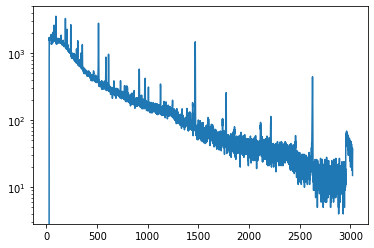

In [71]:
plt.plot(energies,counts)
plt.yscale('log')

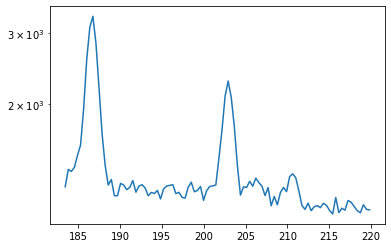

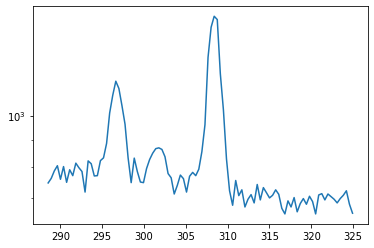

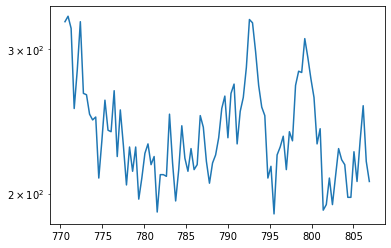

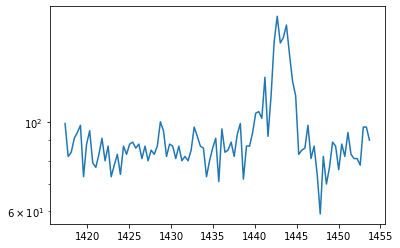

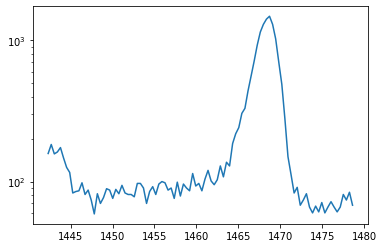

In [72]:
for i in source_energies:
    index0 = f_near(energies, i)
    plt.plot(energies[index0-50:index0+50], counts[index0-50:index0+50])
    plt.yscale('log')
    plt.show()

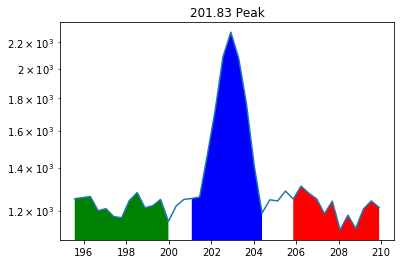

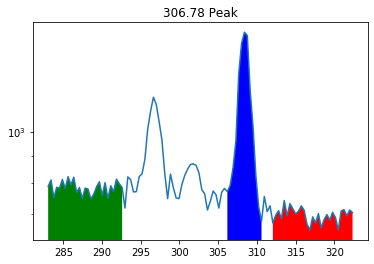

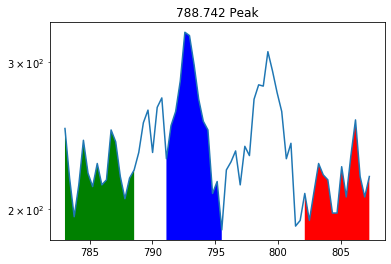

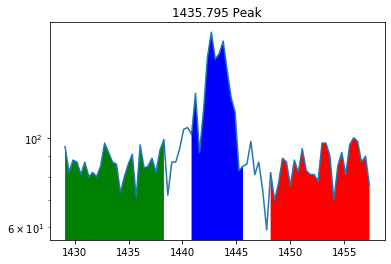

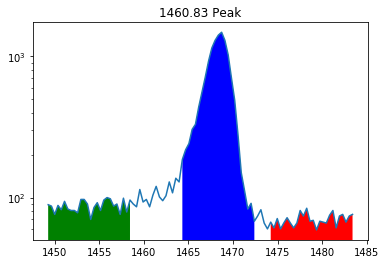

In [73]:
#roi.set_sideband(float(source_energies[0]), 7, [[-.8, -.4], [-.4, .5], [.6, 1.2]])
roi.set_sideband(float(source_energies[0]), 5, [[-1.5, -.5], [-.4, .4], [.5, 1.5]])
roi.set_sideband(float(source_energies[1]), 5, [[-5, -3], [-.4, .6], [.8, 3]])
roi.set_sideband(float(source_energies[2]), 5, [[-2, -.8], [-.4, .6], [1.8, 3]])
roi.set_sideband(float(source_energies[3]), 5, [[-2.8, -.8], [-.5, .6], [1, 3]])
roi.set_sideband(float(source_energies[4]), 5, [[-4, -2], [-1, .8], [1, 3]])

#plot_peak_region(roi, spec, source_energies, float(source_energies[0]))
plot_peak_region(roi, spec, source_energies, float(source_energies[0]))
plot_peak_region(roi, spec, source_energies, float(source_energies[1]))
plot_peak_region(roi, spec, source_energies, float(source_energies[2]))
plot_peak_region(roi, spec, source_energies, float(source_energies[3]))
plot_peak_region(roi, spec, source_energies, float(source_energies[4]))

In [74]:
roi_counts=[]
roi_unc =[]
roi_counts, roi_unc = roi.get_counts()

background spec sidebands 16822.92276785952
bg peak counts 13221.997727721267
signal bg 15241.5
signal peak 16511.0
background spec sidebands 23257.392351239527
bg peak counts 10354.871778938215
signal bg 20655.0
signal peak 13642.0
background spec sidebands 4130.966684357726
bg peak counts 3425.3033652127997
signal bg 3403.0
signal peak 3364.9999999999995
background spec sidebands 2289.43501291714
bg peak counts 1268.8325661281117
signal bg 2232.5
signal peak 1829.9999999999995
background spec sidebands 2137.4110824261106
bg peak counts 11055.543267529703
signal bg 2041.0
signal peak 13540.999999999998


In [75]:
print(roi_counts)
print(roi_unc)

[4870.425040138252, 5889.520572301311, 667.6633191449259, 618.1024467890277, 2581.8678148964045]
[213.92804657559756, 214.36666707899803, 102.74865793474707, 73.21065545797744, 163.3577326261073]


In [76]:
eff,eff_uncer = efficiency(roi_counts,source_activities,branching_ratio,roi_unc,activities_uncer)
print(eff,eff_uncer)

[0.034813854864997516, 0.03851552230420143, 0.016853082527894636, 0.008037431315299992, 0.005524433158739212] [0.0038024170892016758, 0.0040987489080387685, 0.0025937890622646604, 0.0009521228791754796, 0.00034971179452554784]


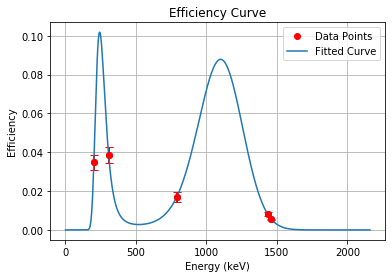

In [77]:
plot_eff = am.Efficiency(source_energies,eff,eff_uncer)

plot_eff.mutate()
plot_eff.fitting()
plot_eff.plotter()